<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning with Python</h1>
<h2 align="center" style="margin-top:20px">Lecture 8: Boosting</h2>
<br>

Boosting is one the most powerful learning algorithms developed in recent decades. In most settings, a carefully tuned boosting model is likely to be among the best algorithms immediately available for prediction, if not the best. 

A large scale empirical study by [Caruana and Niculescu-Mizil (2006)](https://dl.acm.org/ft_gateway.cfm?id=1143865&ftid=364245&dwn=1&CFID=7573757&CFTOKEN=aea5af1b7b29f94-E2D75B9E-EE4F-186B-FF2FDBF1F8C435D1) found that boosting was overall the most accurate algorithm for supervised learning across a variety of datasets, among competitors that included random forests, support vector machines, and neural networks.  Boosting is also behind [winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) to several machine learning competitions. 

In this lesson we will study a regression problem to illustrate how to using boosting with Python. Due to the importance of this topic, we will move beyond Scikit-Learn to consider two specialised packages for gradient boosting: [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html) and [LightGBM](https://github.com/Microsoft/LightGBM).  

<a href="#California-Housing-Data">California Housing Data</a> <br>
<a href="#Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#Gradient Boosting Machines">Gradient Boosting Machines</a> <br>
<a href="#XGBoost">XGBoost</a> <br>
<a href="#LightGBM">LightGBM</a> <br>
<a href="#Benchmark-Models">Benchmark Models</a> <br>
<a href="#Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Methods
from sklearn.linear_model import LinearRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. California Housing Data

**1.1 Loading the data**

We use the California housing dataset, which we can obtain directly from the Scikit-Learn distribution. 

In [4]:
data = pd.read_csv('Data\cal_housing.csv')
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


I prefer to work with pandas, so that the next cells stores the dataset in a dataframe. 

Some of the predictors have severe outliers, which we remove for simplicity. 

In [5]:
data=data[data['AveRooms']<data['AveRooms'].quantile(.99)]
data=data[data['Population']<data['Population'].quantile(.99)]
data=data[data['AveOccup']<data['AveOccup'].quantile(.99)]

**1.2 Data Splitting**

The following cell identifies the variables and splits the data into training and test samples. Note that: 

(a) The training set is only a small fraction of the data. This is to reduce the running times during our session, since the original dataset is large (20,640 observations) and methods such as random forests and boosting are relatively computationally intensitive.<br/>

(b) The response is very right skewed, so that we work with work with its log transformation. 

In [6]:
response = data.columns[-1] # last column in the dataframe
predictors= list(data.columns[:-1]) # all columns except the last
    
index_train, index_test  = train_test_split(np.array(data.index), train_size=0.2, random_state=1)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

y_train = np.log(train[response])
y_test = np.log(test[response])

X_train = train[predictors].copy()
X_test = test[predictors].copy()

### 2. Exploratory Data Analysis

A key feature of this dataset is the presence of geographical information. The next cell draws a map to allow us to visualise the relationship between location and median house prices.  Warmer colours indicate higher prices, while the size of the bubbles indicates the population of the area.  

The house prices are higher near the coast, around the Bay area, and around Los Angeles.  As we will see, these geographical patterns will be crucial for predictive accurarcy. 

Note the following technical details:

(a) You need to install the basemap package to run the cell and render the map, with additional installation required for the full resolution option (you can remove it).<br/>

(b) The cell will take nearly a minute to run because of the full resolution option. <br/>

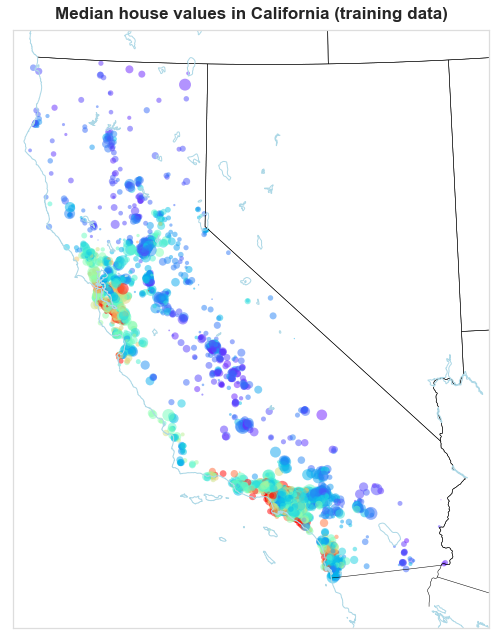

In [7]:
# These next two lines shouldn't be necessary, but they fix an error that I'm getting at the moment.
# This will be different for your computer, if you need it
import os
os.environ['PROJ_LIB'] = r'C:\Users\marce\Anaconda3\Library\share'

from mpl_toolkits.basemap import Basemap

def california_map(ax=None, lllat=31.5, urlat=42.5,
                   lllon=-124,urlon=-113):
# This function is based on "Data Analytics Using Open-Source Tools" by Jeffrey Strickland
    
    m = Basemap(ax=ax, projection='stere',
                lon_0=(urlon + lllon) / 2,
                lat_0=(urlat + lllat) / 2,
                llcrnrlat=lllat, urcrnrlat=urlat,
                llcrnrlon=lllon, urcrnrlon=urlon, resolution='f')
    m.drawstates()
    m.drawcountries()
    m.drawcoastlines(color='lightblue')
    return m


# Plot Figure
fig, ax = plt.subplots(figsize=(9,9))
m = california_map()
x, y = m(train['Longitude'].as_matrix(), train['Latitude'].as_matrix())

cmap = sns.diverging_palette(220, 10, as_cmap=True)
m.scatter(x,y,s=train['Population']/30, c=train['MedianHouseValue'], edgecolors='none', cmap=plt.get_cmap('rainbow'),
         alpha=0.5)

ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')
ax.spines['bottom'].set_color('#DDDDDD')
ax.spines['top'].set_color('#DDDDDD')
ax.spines['right'].set_color('#DDDDDD')
ax.spines['left'].set_color('#DDDDDD')

plt.tight_layout()
plt.show()

The two variables with strongest linear relationship with house values are the median income of the area, and the average number of rooms. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

In [8]:
train.corr().round(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
MedInc,1.000,-0.115,0.676,-0.165,-0.009,-0.080,-0.082,-0.015,0.694
HouseAge,-0.115,1.000,-0.211,-0.111,-0.318,-0.014,0.013,-0.112,0.125
AveRooms,0.676,-0.211,1.000,0.259,-0.078,-0.028,0.132,-0.078,0.324
AveBedrms,-0.165,-0.111,0.259,1.000,-0.056,-0.110,0.086,0.001,-0.106
Population,-0.009,-0.318,-0.078,-0.056,1.000,0.190,-0.127,0.118,-0.036
AveOccup,-0.080,-0.014,-0.028,-0.110,0.190,1.000,-0.175,0.184,-0.298
Latitude,-0.082,0.013,0.132,0.086,-0.127,-0.175,1.000,-0.925,-0.150
Longitude,-0.015,-0.112,-0.078,0.001,0.118,0.184,-0.925,1.000,-0.043
MedianHouseValue,0.694,0.125,0.324,-0.106,-0.036,-0.298,-0.150,-0.043,1.000


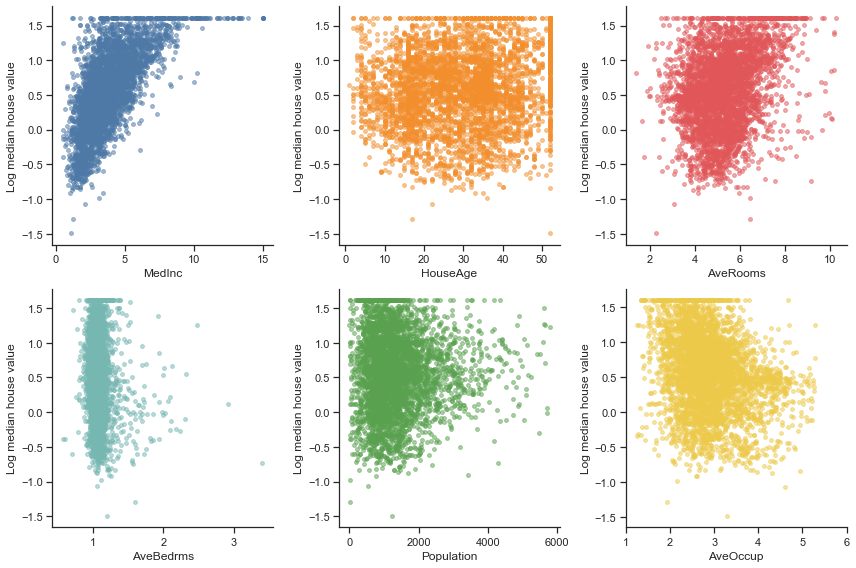

In [9]:
fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, ax in enumerate(fig.axes):
    sns.regplot(X_train.iloc[:,i], y_train, scatter_kws = {'s': 15, 'alpha': 0.5}, ax=ax, fit_reg=False)
    ax.set_ylabel('Log median house value')

ax.set_xlim(1, 6) # fixes a bug in the last plot

sns.despine()
plt.tight_layout()
plt.show()

### 3.Gradient Boosting Machines

We start with the Scikit-Learn implementation of boosting available in the [<TT>GradientBoostingRegressor</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Recall that boosting has three crucial tuning parameters:

<ol>
<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of boosting iterations (trees).</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 
</ol>

In addition, we may want to use stochastic gradient boosting by fitting each tree based on a subsample of the training data. 

The basic syntax for fitting a gradient boosting regressor with Scikit-Learn is as follows. 

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0)
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=750, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

Careful hyperparameter optimisation is very important for gradient boosting. First, I illustrate how you can do a random search.

Below, I configure the random search such that it runs in a reasonable amount of time for illustrative purposes. It is useful to keep track of the running time, as this process can be slow.  Usually, we would try more hyperparameter combinations to increase the chances that we find a configuration that optimises predictive performance.  

In [11]:
%%time

model = GradientBoostingRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500, 2000],
    'max_depth' : [2 ,3, 4],
    'subsample' : [0.6, 0.8, 1.0]
}

# Using GridSearchCV would be too slow. Increase the number of iterations to explore more 
# hyperparameter combinations.
gb = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5, n_jobs=4, random_state=87)
gb.fit(X_train, y_train)

print('Best parameters found by randomised search:', gb.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 4, 'learning_rate': 0.05} 

Wall time: 1min 4s


In [12]:
gb.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

We can make a variable importance plot to help with interpretation.

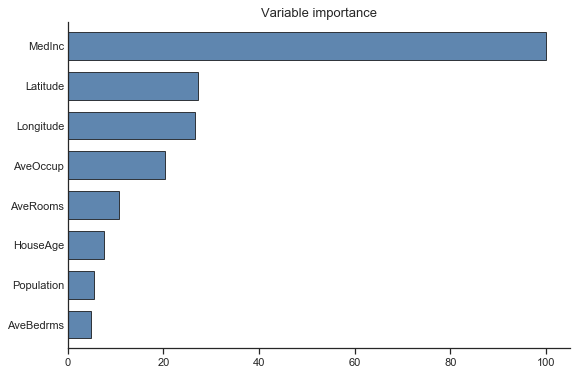

In [13]:
from statlearning import plot_feature_importance
plot_feature_importance(gb.best_estimator_, predictors)
plt.show()

Bayesian hyperparameter optimisation can be very useful for gradient boosting. 

In [14]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [15]:
%%time
# if there is an "unexpected keyword argument fit_params" error: conda install scikit-learn==0.20.3

model = GradientBoostingRegressor()

space = {
    'learning_rate': Real(0.005, 0.15),
    'n_estimators' : Integer(100, 2500),
    'max_depth' : Integer(2, 8),
    'subsample' : Real(0.5, 1.0),
}

np.random.seed(87)
gb_opt =  BayesSearchCV(model, space, cv = 5,  n_iter=32, scoring = 'neg_mean_squared_error', n_jobs=4)
gb_opt.fit(X_train, y_train)
gb_opt.best_params_

Wall time: 4min 36s


{'learning_rate': 0.02762940189069424,
 'max_depth': 5,
 'n_estimators': 2500,
 'subsample': 0.5}

### 4. XGBoost

**4.1 Scikit-Learn API**

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a state-of-art gradient boosting library that is very popular among [Kaggle](https://www.kaggle.com/) users. The easiest way to get started with XGBoost is to use the [Scikit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) provided by the package. That makes the syntax similar to what we did above, except that we call the [XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) class from the XGBoost package. 

The counterpart to our basic syntax from above is:

In [16]:
import xgboost as xgb

xbst = xgb.XGBRegressor(learning_rate= 0.05, max_depth = 4, n_estimators= 750, subsample = 1.0,  reg_lambda=0,
                       objective='reg:squarederror')
xbst.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=750,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
       seed=None, silent=None, subsample=1.0, verbosity=1)

As explained in the lecture notes, XGBoost implements a different version of gradient boosting that incorporates regularisation. Above, I set `reg_lambda=0` to fit a standard gradient boosting model without regularisation.

More generally, it's useful to pay attention to the following additional hyperparameters for XGBoost:

* `reg_lambda`: penalty for $\ell_2$ regularisation.

* `reg_alpha`: penalty for $\ell_1$ regularisation.

*  `colsample_bytree`: fraction of predictors to be sampled to construct each tree (see also `colsample_bylevel` and `colsample_bynode`).

See the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) for additional hyperparameters that may be useful to tune.

Let's start simple with a randomised search that mirrors the one that we did for GBM.

In [17]:
%%time

model = xgb.XGBRegressor(objective='reg:squarederror', reg_lambda=0)

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500, 2000],
    'max_depth' : [2,3,4],
    'subsample' : [0.6, 0.8, 1.0]
}

xbst = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5, random_state=87, n_jobs=4)
xbst.fit(X_train, y_train)

print('Best parameters found by randomised search:', xbst.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 0.8, 'n_estimators': 1500, 'max_depth': 4, 'learning_rate': 0.05} 

Wall time: 1min 53s


XGBoost also supports regularisation of the tree weights (the alpha and lambda hyperparameters), even though we do not use these features here.

In [18]:
xbst = xbst.best_estimator_

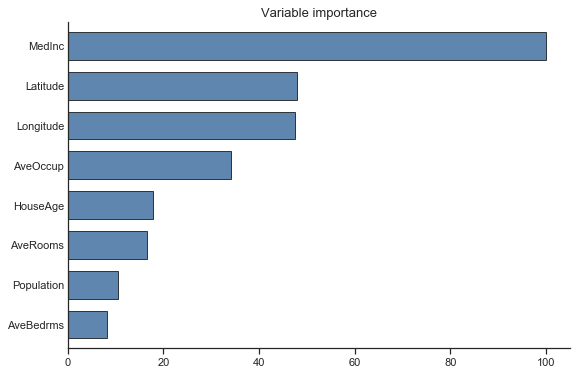

In [19]:
plot_feature_importance(xbst, labels=predictors)
plt.show()

In [20]:
%%time

model = xgb.XGBRegressor(objective='reg:squarederror')

space = {
    'reg_lambda':  (1e-10, 1000, 'log-uniform'),
    'learning_rate': Real(0.005, 0.15),
    'n_estimators' : Integer(100, 2500),
    'max_depth' : Integer(2, 8),
    'subsample' : Real(0.5, 1.0),
    'colsample_bytree' : Real(0.25, 1.0),
}

np.random.seed(87)
xbst_opt =  BayesSearchCV(model, space, cv = 5,  n_iter=32, scoring = 'neg_mean_squared_error', n_jobs=4)
xbst_opt.fit(X_train, y_train)
xbst_opt.best_params_

Wall time: 5min 51s


{'colsample_bytree': 0.6681027664659138,
 'learning_rate': 0.007443203180144262,
 'max_depth': 6,
 'n_estimators': 2093,
 'reg_lambda': 0.00014460929854619208,
 'subsample': 0.9552424116506819}

**4.2 Early Stopping**

The XGBoost functionately extends well beyond the Scikit-Learn API. Below, we construct a pure XGBoost implementation to select the number of boosting iterations by cross-validation and early stopping. 

In [21]:
%%time

dtrain = xgb.DMatrix(X_train, y_train) # we need to convert the data to the format required by xgboost
dtest  = xgb.DMatrix(X_test)

param = {
    'max_depth': 4, 
    'learning_rate': 0.05, 
    'subsample': 0.8,
    'silent' : 0, 
    'objective':'reg:squarederror',  
     }

cv = xgb.cv(param, dtrain, num_boost_round = 2000, nfold=5, early_stopping_rounds=50)

print(f'Selected number of boosting iterations: {cv.shape[0]}')
print(f'RMSE (CV): {cv.iloc[-1,2]:.4f}')

Selected number of boosting iterations: 1129
RMSE (CV): 0.2247
Wall time: 21 s


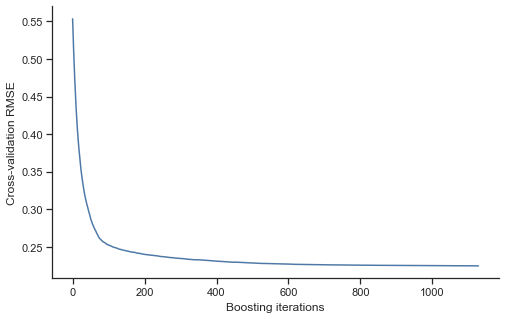

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(cv.iloc[:,2])
ax.set_ylabel('Cross-validation RMSE')
ax.set_xlabel('Boosting iterations')
sns.despine()
plt.show()

It's useful to note that fitting a XGBoost model with early stopping is also possible with the Scikit-Learn API, if there is a validation set. 

### 5. LightGBM

[LightGBM](http://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting library developed by Microsoft, and a competitor to XGBoost. Similarly to XGBoost, it provides an [Scikit-Learn API](http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api) that makes it simple to use. Notice how it runs much faster than the the Scikit-Learn implementation of boosting. 

As with XGBoost, we LightGBM can involve many additional details, such that we keep things simple in this section. It's important to note however that because of the way LightGBM [works](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), we should tune the number of leaves rather than the depth of the trees. 

In [23]:
import lightgbm as lgb

In [24]:
%%time

model = lgb.LGBMRegressor(objective='regression')

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500, 2000],
    'num_leaves' : list(np.arange(2, 64)),
    'subsample' : [0.6, 0.8, 1.0],
}


lbst = RandomizedSearchCV(model, tuning_parameters, n_iter = 32, cv = 5, n_jobs=4, random_state=87)
lbst.fit(X_train, y_train)

print('Best parameters found by randomised search:', lbst.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 1.0, 'num_leaves': 11, 'n_estimators': 1000, 'learning_rate': 0.05} 

Wall time: 1min 16s


### 6. Benchmark Models

**6.1 Linear Regression**

In [25]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**6.2 Regression Tree**

The basic syntax for fitting a regression tree by recursive binary splitting is the following, where we allow the tree to have a maximum depth of two for visualisation.  I also specify the minimum number of samples in the terminal nodes to highlight the importance explictly controlling this tuning parameter.

In [26]:
from sklearn.tree import DecisionTreeRegressor 

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=10, return_train_score=False)
tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'min_samples_leaf': 10, 'max_depth': 12}


**6.3 Random Forest**

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=2000, max_features = 3, min_samples_leaf= 1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Recall that the key tuning parameters for a random forest are (i) the number of randomly selected candidate variables for each split (b) the mininum node size. I selected the specification above with a grid search (omitted here to save time). 

### 7. Model Evaluation

In [28]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['Linear regression', 'Decision tree', 'Random forest', 'GBM', 'GBM (opt)', 'XGBoost', 
      'XGBoost (opt)', 'LightGBM']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[ols, tree, rf, gb, gb_opt, xbst, xbst_opt, lbst]

for i, method in enumerate(methods):
    
    y_pred=method.predict(X_test)   
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
Linear regression,0.326,0.674,0.247
Decision tree,0.305,0.715,0.221
Random forest,0.252,0.805,0.181
GBM,0.234,0.832,0.164
GBM (opt),0.232,0.835,0.162
XGBoost,0.233,0.834,0.162
XGBoost (opt),0.231,0.837,0.162
LightGBM,0.233,0.834,0.164


### 8. Exercise

If you're looking for a challenge: 

1. Split the training data to obtain a validation set.

2. Fit the [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.fit) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMModel.fit) models using the Scikit-Learn API and early stopping. Analyse the results.

### Formatting

The two cells below format the notebook for display online. Please omit them from your work.

In [29]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Source+Sans+Pro|Open+Sans:800&display=swap');
</style>

In [30]:
from IPython.core.display import HTML
style = open('jstyle.css', "r").read()
HTML('<style>'+ style +'</style>')